## Tensorflow Regression

### Create Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
x_data = np.linspace(0, 10, 10000)

In [3]:
noise = np.random.randn(len(x_data))

In [4]:
y_true = (0.5*x_data) + 2 + noise

In [5]:
my_data = pd.concat([pd.DataFrame(data=x_data, columns=['x']), pd.DataFrame(data=y_true, columns=['y'])], axis=1)


In [6]:
my_data.head()

,x,y
0,0.000,3.247793
1,0.001,1.985414
2,0.002,1.893743
3,0.003,0.176515
4,0.004,1.203611


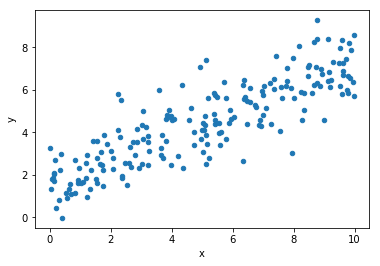

In [7]:
my_data.sample(n=200).plot(kind = 'scatter', x = 'x', y = 'y')

## TensorFlow

### Batch Size

In [8]:
import tensorflow as tf

In [9]:
batch_size = 8

** Variable -- needs to be updated during training **

In [10]:
import numpy as np
np.random.seed(2)
rnd = np.float32(np.random.random(2))
m = tf.Variable(initial_value=rnd[0])
b = tf.Variable(initial_value=rnd[1])

Instructions for updating:
Colocations handled automatically by placer.


** Placeholders -- contain the data **

In [11]:
xph = tf.placeholder(tf.float32, [batch_size])
yph = tf.placeholder(tf.float32, [batch_size])

** Graph **

In [12]:
y_model = m*xph + b

** Loss function **

In [13]:
error = tf.reduce_sum(tf.square(yph-y_model))

** Optimizer -- update the variables **

In [14]:
#be careful about the learning_rate, if it is too large, then you might
#get nan values for the variables
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(error)

** Initialize Variables **

In [15]:
init = tf.global_variables_initializer()

### Session 

In [16]:
with tf.Session() as sess:
    sess.run(init)
    batches = 3000
    for i in range(batches):
        #randomly fetch data to form one batch
        rand_ind = np.random.randint(len(x_data), size = batch_size)
        sess.run(train, {xph: x_data[rand_ind], yph: y_true[rand_ind]})
    
    model_m, model_b = sess.run([m, b])#m.eval(), b.eval()
    

In [17]:
model_m, model_b

(0.45787916, 2.025542)

## Results

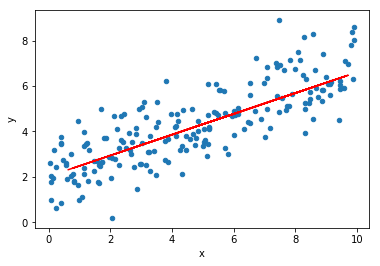

In [18]:
x_plot = my_data.sample(n=20).iloc[:, 0].to_numpy()
y_plot = model_m*x_plot + model_b
#plt.plot(x_plot, y_plot) #place this line below the sample data
my_data.sample(n=200).plot(kind = 'scatter', x = 'x', y = 'y')
plt.plot(x_plot, y_plot, 'r')

## tf.estimator API

### Train Test Split

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
x_train, x_eval, y_train, y_eval = train_test_split(x_data, y_true, test_size = 0.2, random_state = 0)

In [21]:
print (x_train.shape, y_train.shape, '\n', x_eval.shape, y_eval.shape)

(8000,) (8000,) 
 (2000,) (2000,)


### Set up estimator

In [22]:

feat_cols = [tf.feature_column.numeric_column('x', shape=(1,))]


In [23]:
#not show warnings
tf.logging.set_verbosity(tf.logging.ERROR)

In [24]:
estimator = tf.estimator.LinearRegressor(feature_columns=feat_cols)


!!! Training progress is determined by min(Epochs, steps), i.e. it always comes to the smaller values. One epoch is num_samples/batch_size = steps.

In [36]:
input_func = tf.estimator.inputs.numpy_input_fn(
             {'x': x_train}, y_train, batch_size=4, num_epochs=1, shuffle=True)

In [109]:
train_input_func = tf.estimator.inputs.numpy_input_fn(
             {'x': x_train}, y_train, batch_size=4, num_epochs=1, shuffle=False)

In [49]:
eval_input_func = tf.estimator.inputs.numpy_input_fn(
             {'x': x_eval}, y_eval, batch_size=4, num_epochs=1, shuffle=False)

### Train the Estimator

In [40]:
tf.logging.set_verbosity(tf.logging.INFO)
estimator.train(input_fn=input_func, steps=4000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/mz/trvwr9zx153g2cwg48wfgt4c0000gn/T/tmp5d_ytfii/model.ckpt-12000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 12000 into /var/folders/mz/trvwr9zx153g2cwg48wfgt4c0000gn/T/tmp5d_ytfii/model.ckpt.
INFO:tensorflow:loss = 3.6794422, step = 12001
INFO:tensorflow:global_step/sec: 249.011
INFO:tensorflow:loss = 4.398718, step = 12101 (0.405 sec)
INFO:tensorflow:global_step/sec: 598.273
INFO:tensorflow:loss = 2.254595, step = 12201 (0.165 sec)
INFO:tensorflow:global_step/sec: 646.065
INFO:tensorflow:loss = 6.7600565, step = 12301 (0.155 sec)
INFO:tensorflow:global_step/sec: 615.574
INFO:tensorflow:loss = 5.848013, step = 12401 (0.162 sec)
INFO:tensorflow:global_step/sec: 634.764
INFO:tensorflow:loss = 3.7946372, s

## Evaluation

!!!The steps in .evaluate() and epoches determine the number of steps in the evaluation process. If steps is smaller than epochs-steps, then run evaluation on steps batches; otherwise we run out of all batches available.

In [110]:
train_metrics = estimator.evaluate(input_fn=train_input_func, steps = 100)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-12T18:36:33Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/mz/trvwr9zx153g2cwg48wfgt4c0000gn/T/tmp5d_ytfii/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Finished evaluation at 2019-06-12-18:36:34
INFO:tensorflow:Saving dict for global step 14000: average_loss = 1.048977, global_step = 14000, label/mean = 4.4024553, loss = 4.195908, prediction/mean = 4.438682
INFO:tensorflow:Saving 'checkpoint_path' s

In [105]:
eval_metrics = estimator.evaluate(input_fn= eval_input_func, steps = 100)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-12T18:35:47Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/mz/trvwr9zx153g2cwg48wfgt4c0000gn/T/tmp5d_ytfii/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Finished evaluation at 2019-06-12-18:35:48
INFO:tensorflow:Saving dict for global step 14000: average_loss = 1.1092958, global_step = 14000, label/mean = 4.3952336, loss = 4.4371834, prediction/mean = 4.538011
INFO:tensorflow:Saving 'checkpoint_path'

In [111]:
train_metrics, eval_metrics

({'average_loss': 1.048977,
  'label/mean': 4.4024553,
  'loss': 4.195908,
  'prediction/mean': 4.438682,
  'global_step': 14000},
 {'average_loss': 1.1092958,
  'label/mean': 4.3952336,
  'loss': 4.4371834,
  'prediction/mean': 4.538011,
  'global_step': 14000})

In [112]:
for key in train_metrics:
    print (key, train_metrics[key], eval_metrics[key])

average_loss 1.048977 1.1092958
label/mean 4.4024553 4.3952336
loss 4.195908 4.4371834
prediction/mean 4.438682 4.538011
global_step 14000 14000


## Predictions

In [63]:
input_fn_predict = tf.estimator.inputs.numpy_input_fn(
                    {'x':np.linspace(0, 10, 10)}, shuffle=False)

In [89]:
#.predict() returns a generator, so be careful as you have only one chance
pred = estimator.predict(input_fn=input_fn_predict)

In [90]:
pred = list(pred)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/mz/trvwr9zx153g2cwg48wfgt4c0000gn/T/tmp5d_ytfii/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [91]:
pred

[{'predictions': array([1.993979], dtype=float32)},
 {'predictions': array([2.5635002], dtype=float32)},
 {'predictions': array([3.1330214], dtype=float32)},
 {'predictions': array([3.7025423], dtype=float32)},
 {'predictions': array([4.2720633], dtype=float32)},
 {'predictions': array([4.841584], dtype=float32)},
 {'predictions': array([5.4111056], dtype=float32)},
 {'predictions': array([5.980627], dtype=float32)},
 {'predictions': array([6.550148], dtype=float32)},
 {'predictions': array([7.119669], dtype=float32)}]

In [92]:
pred_values = [i['predictions'] for i in pred]

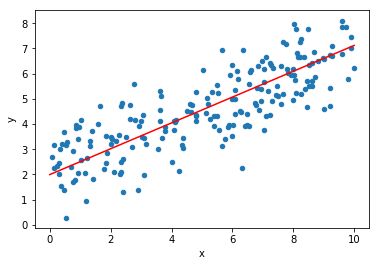

In [96]:
my_data.sample(n=200).plot(kind = 'scatter', x = 'x', y='y')
plt.plot(np.linspace(0, 10, 10), pred_values, 'r')